To get started, we can perform linear regression using linear algebra. Assume a model of $y=\theta_0 + \theta_1 x_1 + \cdots + \theta_n x_n$, where $n$ is the number of features. $\theta_0$ is the bias term. The typical performance metric is mean square error (MSE): $E( \Theta )=\frac{1}{m}\sum_{i=1}^m (\Theta^T x^{(i)}-y^{(i)})$, where $\Theta = [\theta_0 \ \cdots \ \theta_n]$.

In [22]:
import numpy as np
import matplotlib.pyplot as plt

m = 500

X = 1.6 * np.random.rand(m,1)
y = 1.5 + 2.25 * X + np.random.randn(m,1) # theta_0 = 1.5, theta_1 = 2.25

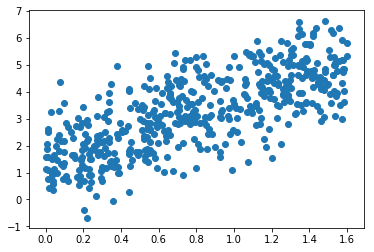

In [23]:
%matplotlib inline
plt.scatter(X,y)
plt.show()

By taking all data instances, $x^{(i)}$, and their target values, $y^{(i)}$, we can compute the parameters using the closed form equation:
$\hat{\Theta}=(X^T\cdot X)^{-1}\cdot X^T\cdot y$

In [24]:
X_b = np.c_[np.ones((500,1)), X] # Adds the bias term, x_0 = 1

In [25]:
theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [26]:
# We get something pretty close to the function that generated this data.
theta

array([[1.46068941],
       [2.26420854]])

In [27]:
# Test the predictions
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)), X_new]

In [28]:
y_predict = X_new_b.dot(theta)
y_predict

array([[1.46068941],
       [5.98910649]])

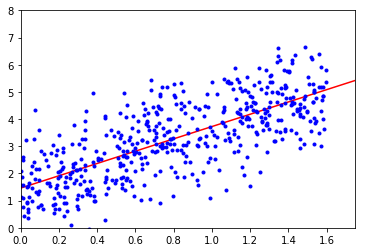

In [29]:
# Plot it
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0,1.75,0,8])
plt.show()

In [30]:
# We can do the same with sklearn linear regression.
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [31]:
print("Model: " + str(linreg.coef_) + "x + " + str(linreg.intercept_))

Model: [[2.26420854]]x + [1.46068941]


In [32]:
linreg.predict(X_new)

array([[1.46068941],
       [5.98910649]])

For data sets with a *large number of *features*, the inversion required to solve the equation becomes very expensive. Instead, *gradient descent* can be applied to adjust parameters, $\Theta$. In linear regression, MSE is the typical cost function. We compute the gradient of MSE along each parameter $\theta_j$. Gradient descent searches through the parameter space following the gradient of a convex function.

In [33]:
# Implementation of gradient descent
def gradient_descent(X, y, n_params, eta, tolerance):
    m = len(X)

    # Initialize the parameters to some random value
    theta = np.random.randn(n_params,1)
    # Compute an initial gradient vector
    gradient_vector = 2/m * X.T.dot(X.dot(theta) - y)
    
    while np.linalg.norm(gradient_vector) > tolerance:
        # Compute the gradient
        gradient_vector = 2/m * X.T.dot(X.dot(theta) - y)
        theta = theta - eta * gradient_vector

    return theta

In [34]:
params = gradient_descent(X_b, y, 2, 0.1, 0.001)
print("Final parameters: " + str(params))

Final parameters: [[1.45808546]
 [2.26704552]]


Nice!

Gradient descent requires the *whole training* set to compute the gradient. This requirement will not scale as the number of instances, $m$, increases. The alternative is to use **stochastic gradient descent**. We lose the smooth convergence guarantees and it will not reach the true optimal value. But, it executes on data point at a time, sometimes allowing quicker convergence to something near the minimum. It is recommended to apply simulated annealing (gradually reduce the step size/learning rate) as you approach the minimum. One approach, shown below, is to set a schedule based on the number of epochs.

In [ ]:
n_epochs = 50
t0, t1 = 5, 50 # For the learning schedule

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1) # again, random initialization

for epoch in range(n_epochs):
    for i in range(m):
        random_idx = np.random.randint(m)
        xi = X_b[random_idx:random_idx+1]
        yi = y[random_idx:random_idx+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

print("Final parameters: " + str(theta))